# 1. FOPDT Simulation for Generating training Data

In [1]:
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

In [2]:
# from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
%matplotlib inline
# from smt.sampling_methods import LHS
# from smt.sampling_methods import Random

In [3]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tf = 30 # fianl time

In [5]:
m=GEKKO(remote=False)
m.time = np.linspace(0,tf-1,tf)

In [6]:
K = m.FV(1) # Process Gain
tau = m.FV(2) # Time Constant

In [7]:
u_input = np.zeros(tf)
u_input[5:] = 1

In [8]:
y = m.CV()
u = m.MV(u_input)
m.Equation(tau*y.dt()+y==K*u) #FOPDT Equation

m.options.IMODE=4

In [9]:
m.solve(disp=False)

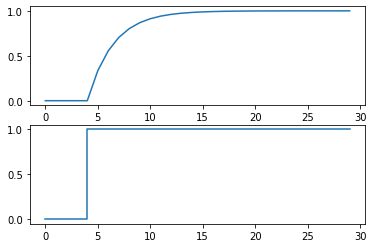

In [10]:
plt.figure(0)
plt.title("label")
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

# 2. Generating input signal (Random and LHS)

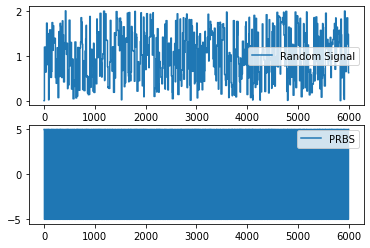

In [11]:
import numpy as np
import matplotlib.pyplot as plt

nstep = 6000 # Choose training data lenth

# random signal generation

a_range = [0,2]
a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
a[0] = 0

b_range = [5, 20]
b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
b = np.round(b)
b = b.astype(int)

b[0] = 0

for i in range(1,np.size(b)):
    b[i] = b[i-1]+b[i]

# Random Signal
i=0
random_signal = np.zeros(nstep)
while b[i]<np.size(random_signal):
    k = b[i]
    random_signal[k:] = a[i]
    i=i+1

# PRBS
a = np.zeros(nstep)
j = 0
while j < nstep:
    a[j] = 5
    a[j+1] = -5
    j = j+2

i=0
prbs = np.zeros(nstep)
while b[i]<np.size(prbs):
    k = b[i]
    prbs[k:] = a[i]
    i=i+1

plt.figure(0) 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

# 3. Evaluate the Random Input Signal

In [12]:
tf = nstep
m.time = np.linspace(0,tf-1,tf)
u.value = random_signal

In [13]:
m.options.IMODE = 4
m.solve(disp=False)

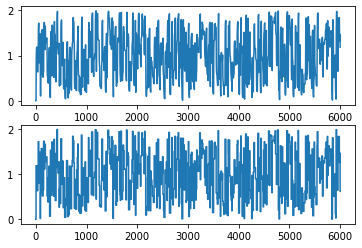

In [14]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

# 4. Train LSTM Network

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

In [16]:
# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [17]:
window = 5 # windodw size for past value
P = 10 # Prediction Horizon for future prediction
#Load training data
data = pd.DataFrame(
        {"u": u,
         "y": y},
        index = np.linspace(1,nstep,nstep,dtype=int))

In [18]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u','y']])
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y']])

In [19]:
Ys = np.reshape(Ys, nstep)

In [20]:
Ys.shape

(6000,)

In [21]:
Ys

array([-1.        , -1.        , -1.        , ...,  0.47366394,
        0.47573254,  0.19138539])

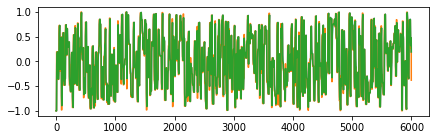

In [22]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [23]:
#%% Save MinMaxScaler file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  joblib.dump(s1, '/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  joblib.dump(s2, '/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
    
else:
  print('Not running on Colab')
  joblib.dump(s1, 's1.sav')
  joblib.dump(s2, 's2.sav')

Running on Colab


In [24]:
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

3000


In [25]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)-P):
    X_train.append(Xs_train[i-window:i+P,:])
    Y_train.append(Ys_train[i:i+P])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)-P):
    X_val.append(Xs_val[i-window:i+P,:])
    Y_val.append(Ys_val[i:i+P])

## (For Training) Preparing new LSTM Input data replacing the *y(k+1), .. y(k+P)* with *y(k)* 

In [26]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [27]:
for i in range(0, len(X_train)):
  X_train[i][window:,1] = X_train[i][window-1,1]

for i in range(0, len(X_val)):
  X_val[i][window:,1] = X_val[i][window-1,1]

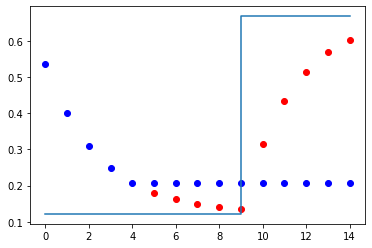

In [28]:
i = 170
t = np.linspace(0, 14, 15)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,1],'bo')
plt.step(t, X_train[i][:,0])

In [29]:
# # Initialize LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [30]:
# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(X_train, Y_train, epochs = 300, batch_size = 250, callbacks=[es], verbose=1, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/300
12/12 [==============================] - 7s 136ms/step - loss: 0.2053 - accuracy: 0.1033 - val_loss: 0.0676 - val_accuracy: 0.0750
Epoch 2/300
12/12 [==============================] - 0s 19ms/step - loss: 0.0586 - accuracy: 0.1753 - val_loss: 0.0349 - val_accuracy: 0.2385
Epoch 3/300
12/12 [==============================] - 0s 19ms/step - loss: 0.0361 - accuracy: 0.2174 - val_loss: 0.0221 - val_accuracy: 0.4620
Epoch 4/300
12/12 [==============================] - 0s 17ms/step - loss: 0.0263 - accuracy: 0.3567 - val_loss: 0.0169 - val_accuracy: 0.4972
Epoch 5/300
12/12 [==============================] - 0s 16ms/step - loss: 0.0223 - accuracy: 0.3623 - val_loss: 0.0144 - val_accuracy: 0.4874
Epoch 6/300
12/12 [==============================] - 0s 16ms/step - loss: 0.0202 - accuracy: 0.3456 - val_loss: 0.0118 - val_accuracy: 0.4911
Epoch 7/300
12/12 [==============================] - 0s 16ms/step - loss: 0.0166 - accuracy: 0.3291 - val_loss: 0.0100 - val_accuracy: 0.5152
Epoch

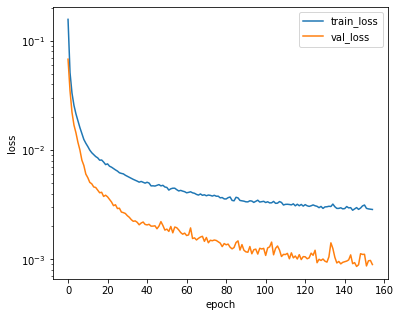

In [31]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(history.history['loss'],label='train_loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss')
# plt.savefig('FOPDT_loss.png')
plt.legend()

In [32]:
#%% Save model file
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model.save('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
    
else:
  print('Not running on Colab')
  model.save('model.h5')

Running on Colab


# 5. Prediction
Input =    
[x(k-W), x(k-w+1), ... x(k) ... x(k+P-1), x(k+P)],\
[y(k-W), y(k-w+1), ... y(k) ... y(k+P-1), y(k+P)]
 
where, y(k), ... y(k+p) : Same with the measured data

Output = \
[y(k) ... y(k+P-1), y(k+P)]

In [33]:
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')

Running on Colab


Runtime: 1.42 s


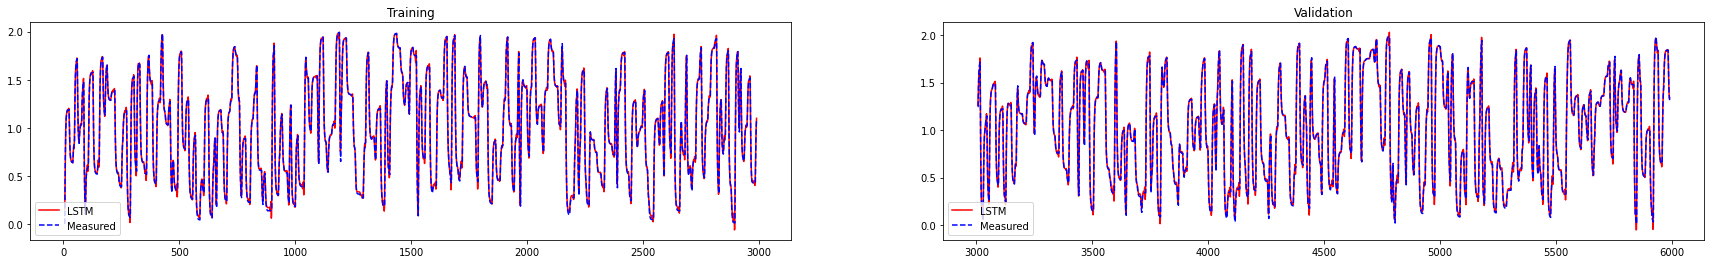

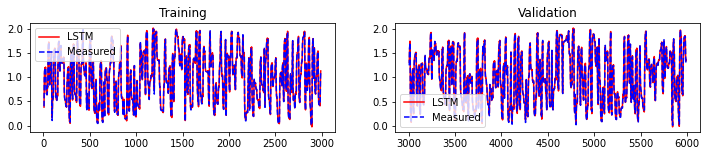

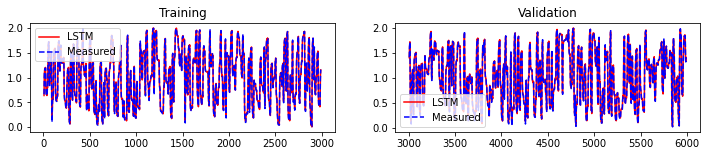

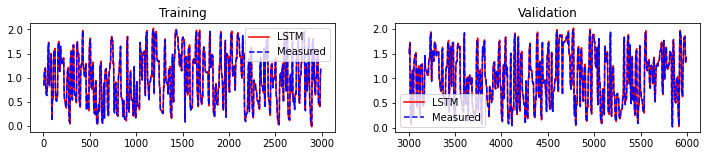

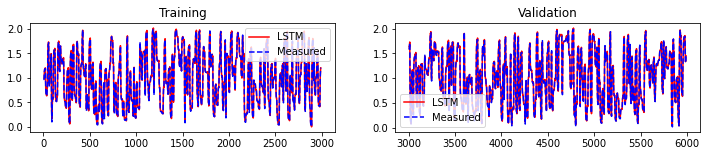

In [34]:
# Verify the fit of the model
t0 = time.time()
Yp_train = model.predict(X_train)
Yp_val = model.predict(X_val)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# un-scale outputs
Yu_train = s2.inverse_transform(Yp_train)
Ym_train = s2.inverse_transform(Y_train)

Yu_val = s2.inverse_transform(Yp_val)
Ym_val = s2.inverse_transform(Y_val)

plt.figure(0, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(1, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(2, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train[:,2],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train[:,2],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val[:,2],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val[:,2],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(3, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train[:,3],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train[:,3],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val[:,3],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val[:,3],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(4, figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train[:,4],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train[:,4],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val[:,4],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val[:,4],'b--',label='Measured')
plt.title('Validation')
plt.legend()



No handles with labels found to put in legend.


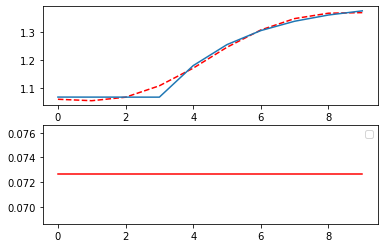

In [35]:
j =206
plt.subplot(2,1,1)
plt.plot(Yu_val[j], 'r--', label='LSTM Prediction')

plt.plot(Ym_val[j], label='Data')
plt.subplot(2,1,2)
plt.plot(X_val[j][window:,1], 'r-')
plt.legend()

# 6. Forecast
Input =  
[x(k-W), x(k-w+1), ... x(k) ... x(k+P-1), x(k+P)],  
[y(k-W), y(k-w+1), ... y(k) ... y(k+P-1), y(k+P)]

where, [y(k+1), ... y(k+p)] = y(k) 

Output =  
[y(k) ... y(k+P-1), y(k+P)]

In [36]:
# Load model files (LSTM and MinMaxScaler)
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  s1 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  s2 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')
  s1 = joblib.load('s1.sav')
  s2 = joblib.load('s2.sav')

Running on Colab


In [37]:
X_train_fcst = X_train.copy()
X_val_fcst = X_val.copy()

## Preparing new LSTM Input data replacing the *y(k+1), .. y(k+P)* with *y(k)*

In [38]:
for i in range(0, len(X_train_fcst)):
  X_train_fcst[i][window:,1] = X_train_fcst[i][window-1,1]

for i in range(0, len(X_val_fcst)):
  X_val_fcst[i][window:,1] = X_val_fcst[i][window-1,1]

In [39]:
X_train_fcst[350]

array([[-0.48481017, -0.44765293],
       [-0.48481017, -0.45942005],
       [-0.48481017, -0.46726479],
       [-0.48481017, -0.47249462],
       [-0.48481017, -0.47598117],
       [-0.48481017, -0.47598117],
       [-0.48481017, -0.47598117],
       [-0.48481017, -0.47598117],
       [-0.48481017, -0.47598117],
       [ 0.77808617, -0.47598117],
       [ 0.77808617, -0.47598117],
       [ 0.77808617, -0.47598117],
       [ 0.77808617, -0.47598117],
       [ 0.77808617, -0.47598117],
       [ 0.77808617, -0.47598117]])

Runtime: 1.34 s


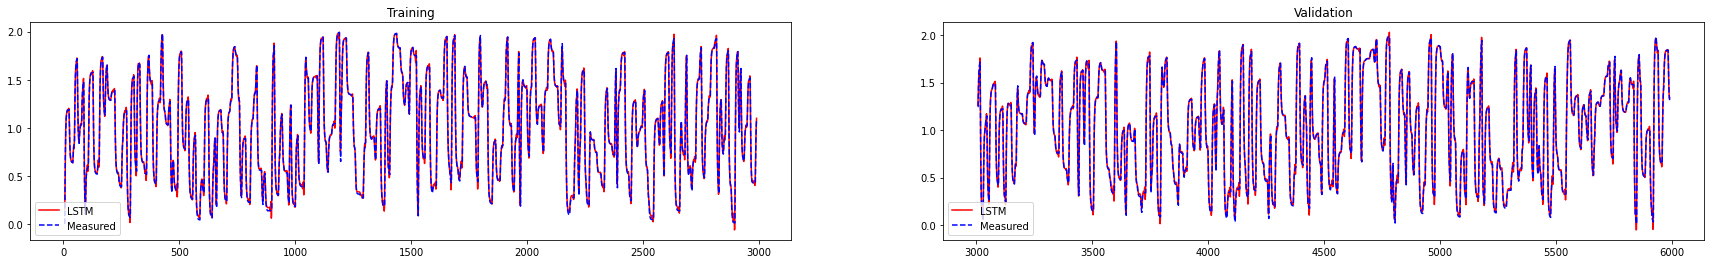

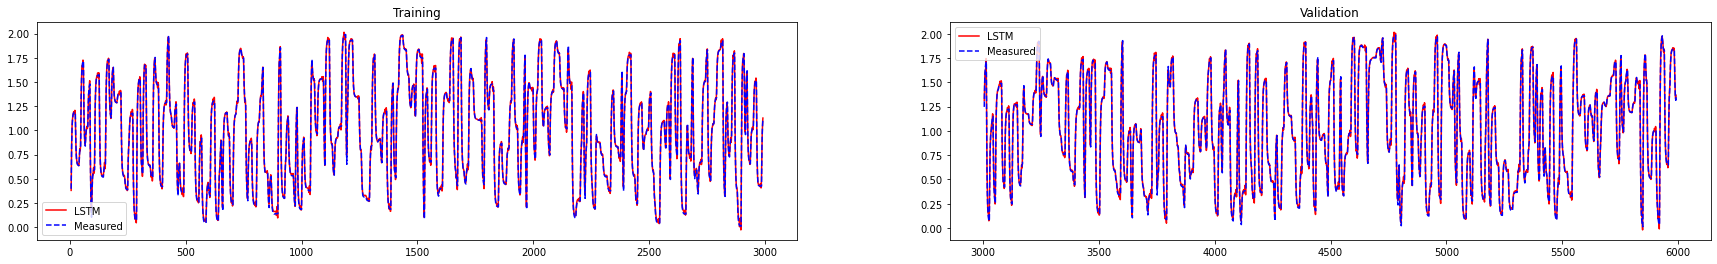

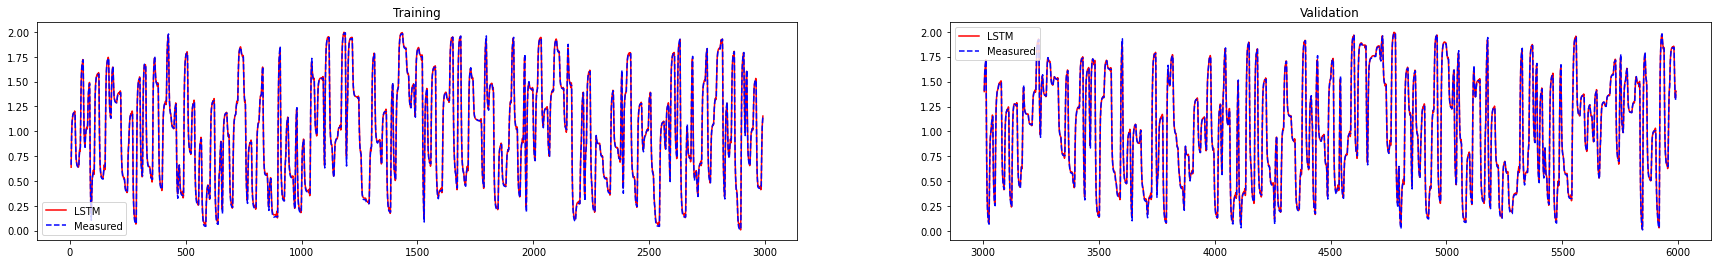

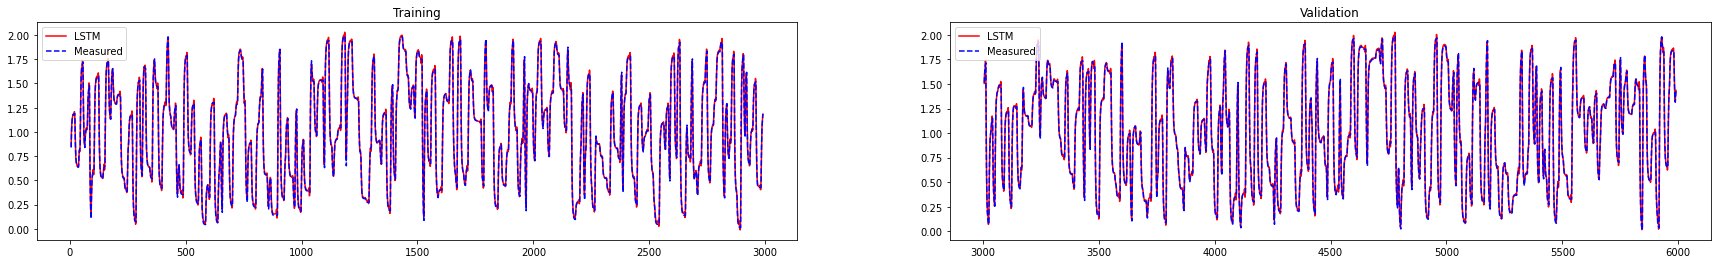

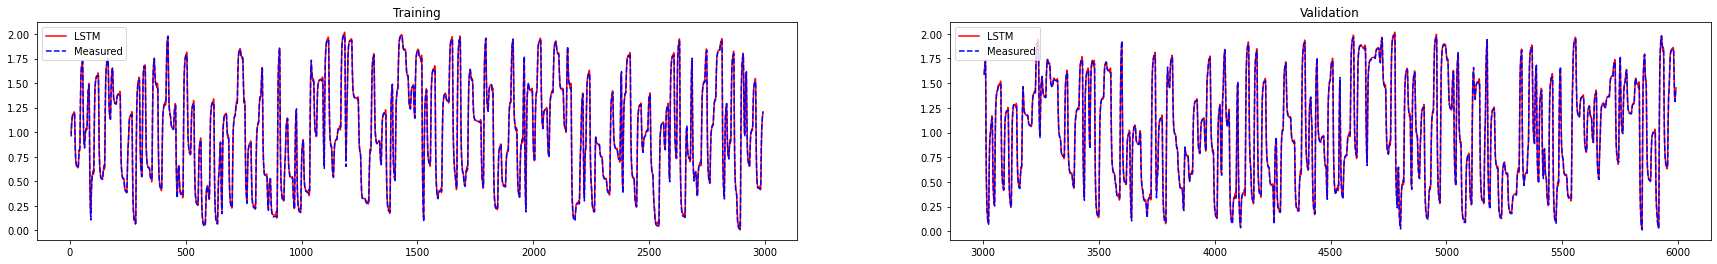

In [40]:
# Verify the fit of the model
t0 = time.time()
Yp_train_fcst = model.predict(X_train_fcst)
Yp_val_fcst = model.predict(X_val_fcst)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# un-scale outputs
Yu_train_fcst = s2.inverse_transform(Yp_train_fcst)
Ym_train_fcst = s2.inverse_transform(Y_train)

Yu_val_fcst = s2.inverse_transform(Yp_val_fcst)
Ym_val_fcst = s2.inverse_transform(Y_val)

plt.figure(0, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train_fcst[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train_fcst[:,0],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val_fcst[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val_fcst[:,0],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(1, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train_fcst[:,1],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train_fcst[:,1],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val_fcst[:,1],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val_fcst[:,1],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(2, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train_fcst[:,2],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train_fcst[:,2],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val_fcst[:,2],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val_fcst[:,2],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(3, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train_fcst[:,3],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train_fcst[:,3],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val_fcst[:,3],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val_fcst[:,3],'b--',label='Measured')
plt.title('Validation')
plt.legend()

plt.figure(4, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Yu_train_fcst[:,4],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Ym_train_fcst[:,4],'b--',label='Measured')
plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Yu_val_fcst[:,4],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Ym_val_fcst[:,4],'b--',label='Measured')
plt.title('Validation')
plt.legend()

No handles with labels found to put in legend.


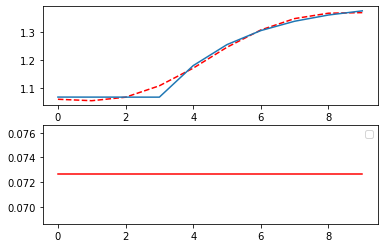

In [41]:
j = 206
plt.subplot(2,1,1)
plt.plot(Yu_val_fcst[j], 'r--', label='LSTM Prediction')

plt.plot(Ym_val_fcst[j], label='Data')
plt.subplot(2,1,2)
plt.plot(X_val_fcst[j][window:,1], 'r-')
plt.legend()

##Computation time for *P*-step ahead prediction

In [42]:
X_in = X_train_fcst[140].reshape((1, window+P, np.shape(Xs)[1]))
t0 = time.time()
Y_out = model.predict(X_in)
t1 = time.time()

print(Y_out)
print('Runtime for ' + str(P) +  ' step prediction: %.2f s' %(t1-t0))

[[-0.4499712  -0.4288616  -0.40264624 -0.38292956 -0.36503077 -0.35617244
  -0.35352173 -0.3508324  -0.34760877 -0.3397587 ]]
Runtime for 10 step prediction: 0.04 s
